<a href="https://colab.research.google.com/github/Azlan-Qaisrani/my-first/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [34]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
transform=transforms.Compose([transforms.ToTensor()])
train_dataset=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_dataset=datasets.MNIST(root='./data',train=False,download=True,transform=transform)

In [36]:
image,label=train_dataset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
5


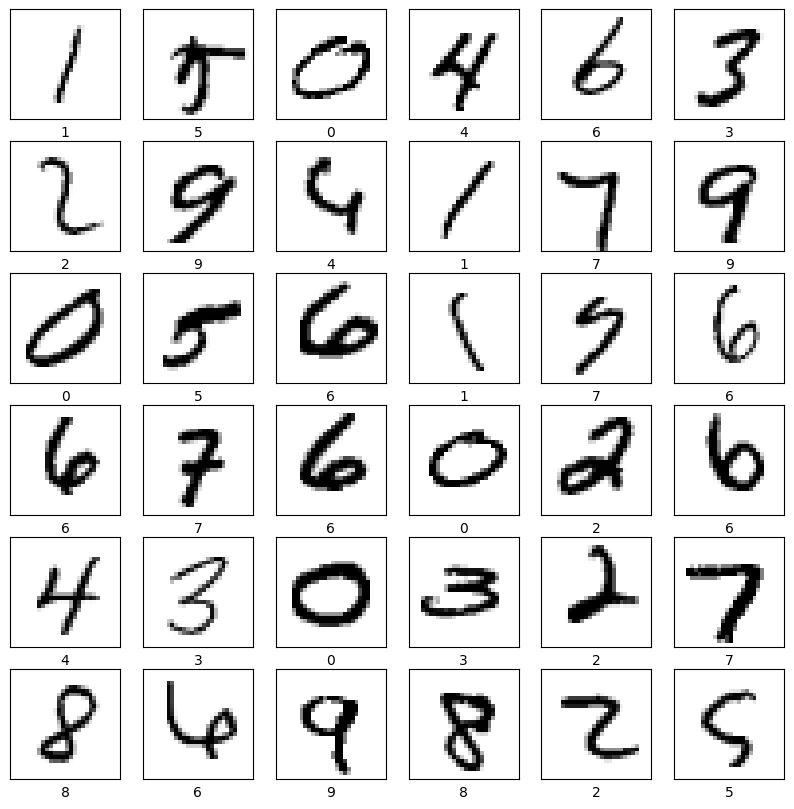

In [37]:
plt.figure(figsize=(10,10))
random_inds=np.random.choice(60000,36)
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_ind=random_inds[i]
  image,label=train_dataset[image_ind]
  plt.imshow(image.squeeze(),cmap=plt.cm.binary)
  plt.xlabel(label)
plt.show()

In [38]:
def build_fc_model():
  fc_model=nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28,128),
      nn.ReLU(),
      nn.Linear(128,10),

  )
  return fc_model
fc_model_sequential=build_fc_model()

In [39]:
class FullyConnectedModel(nn.Module):
  def __init__(self):
    super(FullyConnectedModel,self).__init__()
    self.flatten=nn.Flatten()
    self.fc1=nn.Linear(28*28,128)
    self.relu=nn.ReLU()
    self.fc2=nn.Linear(128,10)
  def forward(self,x):
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
fc_model=FullyConnectedModel().to(device)


In [40]:
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(fc_model.parameters(),lr=0.1)

In [41]:
BATCH_SIZE=64
trainset_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
testset_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [42]:
def train(model,DataLoader,criterion,optimizer,epochs):
  model.train()
  for epoch in range(epochs):
    total_loss=0
    correct_pred=0
    total_pred=0

    for images,labels in trainset_loader:
      images,labels=images.to(device),labels.to(device)

      outputs = fc_model(images)

      optimizer.zero_grad()
      loss=loss_function(outputs,labels)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()*images.size(0)

      predicted=torch.argmax(outputs,dim=1)
      correct_pred+=(predicted==labels).sum().item()
      total_pred+=labels.size(0)


    total_epoch_loss=total_loss/total_pred
    epoch_accuracy=correct_pred/total_pred
    print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")


In [43]:
EPOCHS=5
train(fc_model,trainset_loader,loss_function,optimizer,EPOCHS)


Epoch 1, Loss: 0.4414567701975505, Accuracy: 0.8822
Epoch 2, Loss: 0.22508678840001425, Accuracy: 0.9352
Epoch 3, Loss: 0.16726598476568857, Accuracy: 0.9515
Epoch 4, Loss: 0.13344348714152973, Accuracy: 0.9614
Epoch 5, Loss: 0.11125390760501226, Accuracy: 0.9683


In [44]:
def evaluate(model,DataLoader,loss_function):
  model.eval()
  test_loss=0
  correct_pred=0
  total_pred=0

  with torch.no_grad():
    for images,labels in testset_loader:
      images,labels=images.to(device),labels.to(device)
      outputs=model(images)
      loss=loss_function(outputs,labels)
      test_loss+=loss.item()*image.size(0)


      predicted=torch.argmax(outputs,dim=1)
      correct_pred+=(predicted==labels).sum().item()
      total_pred+=labels.size(0)
  test_loss/=total_pred
  test_acc=correct_pred/total_pred
  return test_loss,test_acc


In [45]:
test_loss,test_acc=evaluate(fc_model,testset_loader,loss_function)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0017, Test Accuracy: 0.9685


In [46]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(1,24,kernel_size=3)
    self.pool1=nn.MaxPool2d(kernel_size=2)

    self.conv2=nn.Conv2d(24,36,kernel_size=3)
    self.pool2=nn.MaxPool2d(kernel_size=2)

    self.flatten=nn.Flatten()
    self.fc1=nn.Linear(36*5*5,128)
    self.relu=nn.ReLU()
    self.fc2=nn.Linear(128,10)


  def forward(self,x):
    x=self.conv1(x)
    x=self.pool1(x)
    x=self.conv2(x)
    x=self.pool2(x)

    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
cnn_model=CNN().to(device)
image,label=train_dataset[0]
image=image.to(device).unsqueeze(0)
output=cnn_model(image)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=900, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [47]:
cnn_model=CNN().to(device)

batch_size=64
epochs=7
optimizer=optim.SGD(cnn_model.parameters(),lr=1e-2)
loss_function=nn.CrossEntropyLoss()

trainset_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
testset_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)



In [48]:
def train(model,DataLoader,criterion,optimizer,epochs):
  model.train()
  for epoch in range(epochs):
    total_loss=0
    correct_pred=0
    total_pred=0

    for images,labels in trainset_loader:
      images,labels=images.to(device),labels.to(device)
      outputs=model(images)

      optimizer.zero_grad()
      loss=loss_function(outputs,labels)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()*images.size(0)

      predicted=torch.argmax(outputs,dim=1)
      correct_pred+=(predicted==labels).sum().item()
      total_pred+=labels.size(0)


    total_epoch_loss=total_loss/total_pred
    epoch_accuracy=correct_pred/total_pred
    print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")



In [49]:
EPOCHS=7
train(cnn_model,trainset_loader,loss_function,optimizer,EPOCHS)

Epoch 1, Loss: 1.0322987193743387, Accuracy: 0.7301
Epoch 2, Loss: 0.2854205062150955, Accuracy: 0.9133
Epoch 3, Loss: 0.19968882891337078, Accuracy: 0.9403
Epoch 4, Loss: 0.15017224497199058, Accuracy: 0.9556
Epoch 5, Loss: 0.12175587638119857, Accuracy: 0.9637
Epoch 6, Loss: 0.10263910508056481, Accuracy: 0.9697
Epoch 7, Loss: 0.08947826179166635, Accuracy: 0.9734


In [50]:
test_loss,test_acc=evaluate(cnn_model,testset_loader,loss_function)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0014, Test Accuracy: 0.9740


In [51]:
test_image, test_label = test_dataset[0]
test_image = test_image.to(device).unsqueeze(0)

# put the model in evaluation (inference) mode
cnn_model.eval()
predictions_test_image = cnn_model(test_image)

In [52]:
print(predictions_test_image)

tensor([[ -0.4606,  -2.3358,   5.5217,   3.4753,  -4.6459,  -2.3680, -10.8511,
          13.2829,  -2.8234,   2.0238]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [53]:

predictions_value = predictions_test_image.cpu().detach().numpy() #.cpu() to copy tensor to memory first
prediction = np.argmax(predictions_value)
# prediction = # TODO
print(prediction)

7


Label of this digit is: 7


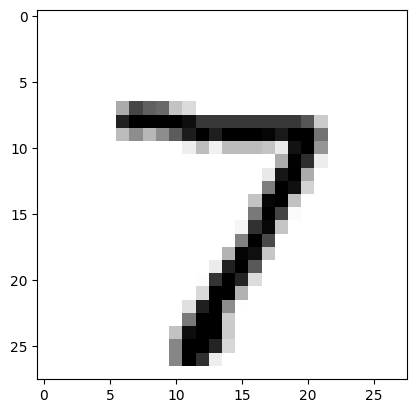

In [54]:

print("Label of this digit is:", test_label)
plt.imshow(test_image[0,0,:,:].cpu(), cmap=plt.cm.binary)
